In [162]:
using Pkg
using Plots
using Polynomials
using Interpolations
using DataFrames
using Statistics
using Printf

In [3]:
xs =  1:1:10
ys = [rand() for x in xs]

10-element Vector{Float64}:
 0.3787469497485507
 0.26134000560604376
 0.7590583074751436
 0.8706527287223244
 0.9406163256302191
 0.6895132609628836
 0.5944936244583587
 0.22568202571015994
 0.4292789270115851
 0.7510707345409628

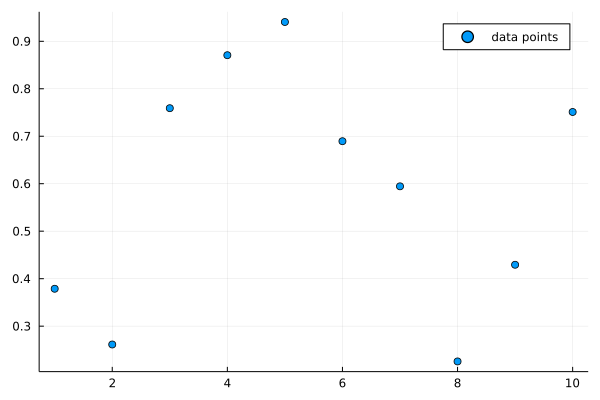

In [4]:
scatter(xs,ys, label="data points")

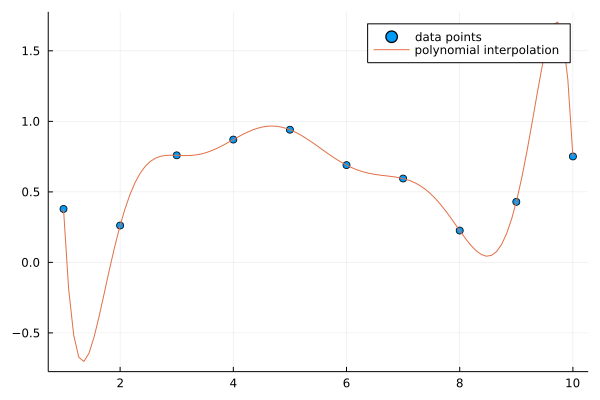

In [5]:
f=fit(xs, ys)
plot!(f,  extrema(xs)..., label="polynomial interpolation")

In [6]:
xsf=1:0.01:10

1.0:0.01:10.0

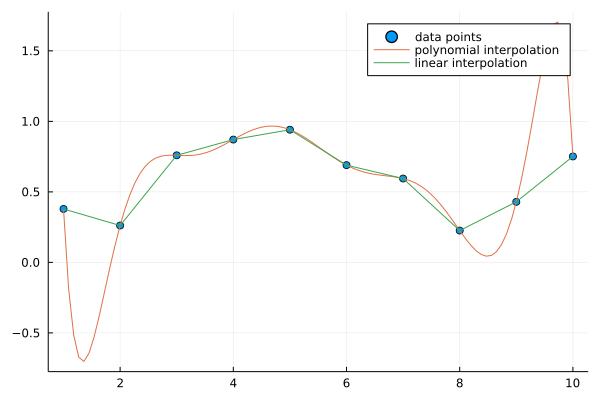

In [7]:
interp_linear = LinearInterpolation(xs, ys)
ysf=[interp_linear(x) for x in xsf]
plot!(xsf,ysf, label="linear interpolation")

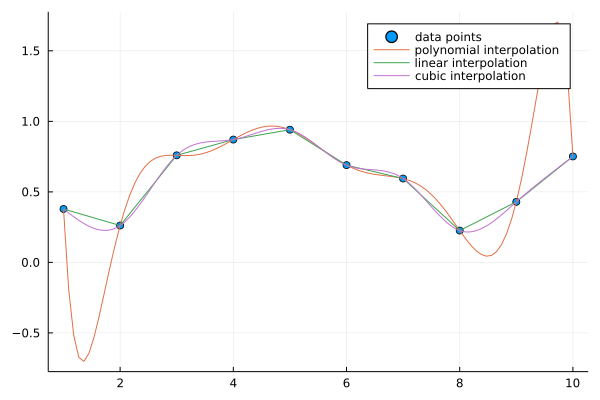

In [8]:
interp_cubic = CubicSplineInterpolation(xs, ys)
ysf2=[interp_cubic(x) for x in xsf]
plot!(xsf,ysf2, label="cubic interpolation")

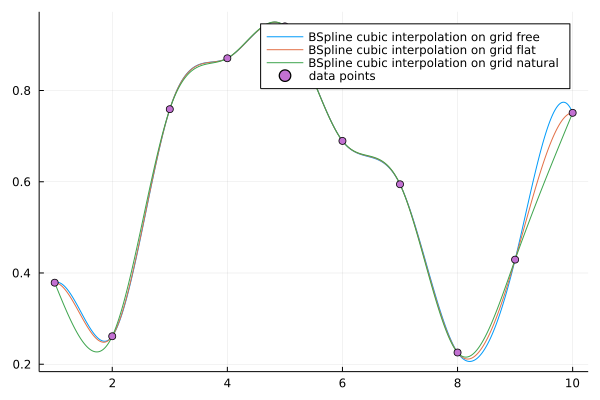

In [9]:
itp = interpolate(ys, BSpline(Cubic(Free(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot(xsf,ysf3, label="BSpline cubic interpolation on grid free")
itp = interpolate(ys, BSpline(Cubic(Flat(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot!(xsf,ysf3, label="BSpline cubic interpolation on grid flat")
itp = interpolate(ys, BSpline(Cubic(Natural(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot!(xsf,ysf3, label="BSpline cubic interpolation on grid natural")

scatter!(xs,ys, label="data points")

# 1. Interpolacja Lagrange'a

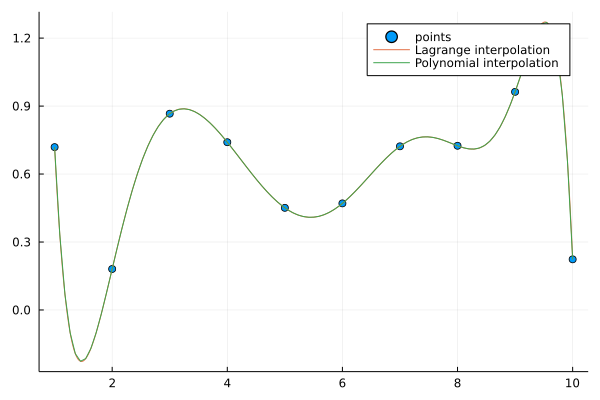

In [10]:
function l_base(x_cord, k, X, Y, n)
    b = [(x_cord - X[i])/(X[k] - X[i]) for i in 1:n if i != k]
    return prod(b) 
end

function l_value(x_cord,X,Y,n)
    values = [Y[k] * l_base(x_cord,k,X,Y,n) for k in 1:n ]
    return sum(values)
end

#Węzły interpolacji
X =  1:1:10
Y = [rand() for x in X]

n = length(X)

scatter(X,Y, label = "points")

#Punkty aby narysować wykres za pomocą wielomianu interpolującego
xs = 1:0.01:10

ys = [l_value(i,X,Y,n) for i in xs]
plot!(xs, ys, label = "Lagrange interpolation")

#Interpolacja wielomianowa z pakietu.
f=fit(X, Y)
plot!(f,  extrema(X)..., label="Polynomial interpolation")

# 2. Metoda Newtona (ilorazów różnicowych)

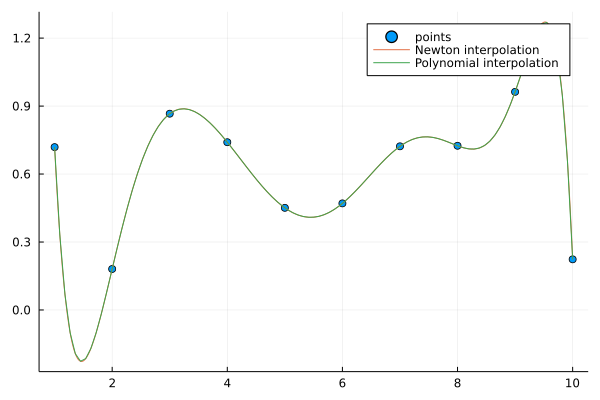

In [23]:
function newton_horner(diagonal, xs, x_coord)
    n = length(xs)
    
    # inicjalizuje nasz wynik jako f[x_0]
    res = diagonal[1]
    # to jest ciąg produktów postaci (x-x_0)(x-x_1)...(x-x_n-1) 
    # zaczynam od 1 bo f[x_0]*1 + ... /to pierwszy człon
    x_prod = 1
    # pierwszy człon już mamy f[x_0] więc zaczynam liczyć od drugiego postaci (x-x_0)f[x_0,x_1]
    for i in 2:n
        x_prod = x_prod * (x_coord - xs[i-1])
        res = res + x_prod * diagonal[i]
    end
    
    return res
end

function NewtonInterpolation(X,Y)
    n = length(X)
    m =  zeros(Float64, n, n)
    
    # zerowe ilorazy roznicowe - wartości funkcji f[x_i]
    for i in 1:n
        m[i,1] = Y[i]
    end
    
    # pierwsze ilorazy roznicowe f[x_i,x_i+1] = (f[x_i+1] - f[x_i])/(x_i+1 - x_i)
    for i in 2:n
        m[i,2] = (m[i,1] - m[i-1,1]) / (X[i] - X[i-1])
    end
    
    # kolejne ilorazy różnicowe [2,..,n]
    for j in 3:n
        for i in j:n
            m[i, j] = (m[i, j-1] - m[i-1, j-1]) / (X[i] - X[i-j+1] )
        end
    end
    
    # wyniki na przekątnej
    diagonal = [m[i,i] for i in 1:n]
    
    # obiekt interpolacyjny
    newt = x -> newton_horner(diagonal, X, x)
    return newt
end

scatter(X, Y, label = "points")

newt = NewtonInterpolation(X,Y)
xs = 1:0.01:10
ys = [newt(i) for i in xs]
plot!(xs, ys, label = "Newton interpolation")

#Interpolacja wielomianowa z pakietu.
f=fit(X, Y)
plot!(f,  extrema(X)..., label="Polynomial interpolation")

#  3. Porównanie interpolacji

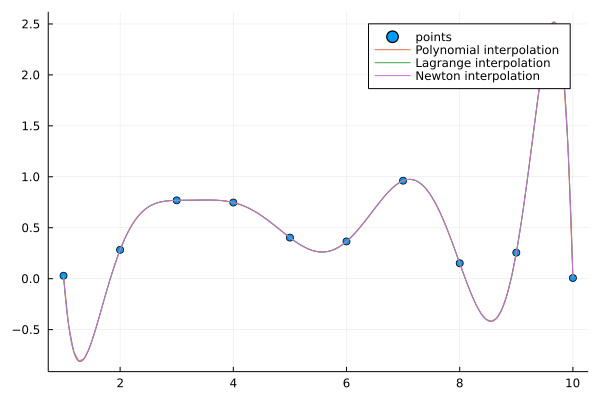

In [28]:
xs = 1:0.01:10
X = 1:1:10
Y = [rand() for x in X]

scatter(X, Y, label="points")

# Interpolacja wielomianowa z pakietu.
f=fit(X, Y)
plot!(f,  extrema(X)..., label="Polynomial interpolation")

# Lagrange
Y1 = [l_value(i,X,Y,n) for i in xs]
plot!(xs, Y1, label = "Lagrange interpolation")

# Newton
newt = NewtonInterpolation(X,Y)
Y2 = [newt(i) for i in xs]
plot!(xs, Y2, label = "Newton interpolation")

Krzywe się pokrywają.\
Wynika to z twierdzenia, o istnieniu tylko 1 wielomianu n-tego stopnia przechodzącego przez punkty.

# 4. Pomiary czasu

In [31]:
function rand_points(n)
    X = [i for i=1:n]
    Y = rand(n)
    return X, Y
end

rand_points (generic function with 1 method)

In [34]:
# Funkcja do pomiaru czasu algorytmu Lagrange'a.
function lagrange_time(X,Y,range)
    return sum([@elapsed l_value(i,X,Y,length(X)) for i in range])
end

# Funkcja do pomiaru czasu algorytmu Newtona.
function newton_time(X,Y,range)
    a = @elapsed NewtonInterpolation(X,Y)
    newt = NewtonInterpolation(X,Y)
    b =  sum([@elapsed newt(i) for i in range])
    return a + b
end

# Funkcja do pomiaru czasu funkcji bibliotecznej.
function polynomials_time(X,Y,range)
    a = @elapsed (fit(X,Y))
    func = fit(X,Y)
    b = sum([@elapsed func(i) for i in range])
    return a + b
end

polynomials_time (generic function with 1 method)

In [49]:
xs, ys = rand_points(10)
r = 1:0.1:10

@printf "Lagrange time: %f \n" lagrange_time(xs,ys,r)
@printf "Newton time:   %f \n" newton_time(xs,ys,r)
@printf "Library time:  %f \n" polynomials_time(xs,ys,r)

Lagrange time: 0.000444 
Newton time:   0.000006 
Library time:  0.000013 


In [50]:
df1 = DataFrame(
    points = Int64[], 
    interpolation = String[],
    time = Float64[])

,points,interpolation,time
,Int64,String,Float64


In [51]:
for i = 0:10:100
    xs, ys = rand_points(i)
    r = 1:0.01:i
    push!(df1, [i "lagrange" lagrange_time(xs,ys,r)])
    push!(df1, [i "newton" newton_time(xs,ys,r)])
    push!(df1, [i "polynomials" polynomials_time(xs,ys,r)])
end

In [52]:
df1

,points,interpolation,time
,Int64,String,Float64
1,0,lagrange,0.0
2,0,newton,3.1e-6
3,0,polynomials,8.7e-6
4,10,lagrange,0.0023466
5,10,newton,3.24e-5
6,10,polynomials,3.84e-5
7,20,lagrange,0.014557
8,20,newton,7.11e-5
9,20,polynomials,0.0001085


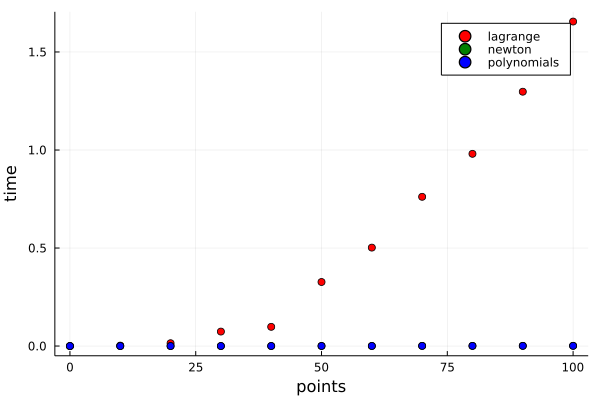

In [71]:
g = groupby(df1,"interpolation")
scatter()
scatter!(g[1][!, "points"], g[1][!, "time"],xlab = "points", ylab="time", colour =:red, label = "lagrange")
scatter!(g[2][!, "points"], g[2][!, "time"],xlab = "points", ylab="time", colour =:green, label = "newton")
scatter!(g[3][!, "points"], g[3][!, "time"],xlab = "points", ylab="time", colour =:blue, label = "polynomials")

## Newton vs Polynomials - wyliczanie wielomianu

In [80]:
# czas wyliczania wielomianu dla algorytmu Newtona
function newton_start_time(X,Y,res_range)
    a = @elapsed  NewtonInterpolation(X,Y)
    return a
end

# czas wyliczania wielomianu dla polynomials
function polynomials_start_time(X,Y,res_range)
    return @elapsed (fit(X,Y))
end

polynomials_start_time (generic function with 1 method)

In [81]:
df2 = DataFrame(points = Int64[], 
    interpolation = String[],
    time = Float64[])

,points,interpolation,time
,Int64,String,Float64


In [82]:
r = 100:100:1000
for i=r
    for j=1:10
        xt, yt = rand_points(i)
        tr = 1:0.01:i
        push!(df2, [i "newton" newton_start_time(xt,yt,tr)])
        push!(df2, [i "polynomials" polynomials_start_time(xt,yt,tr)])
    end
end

In [83]:
df2

,points,interpolation,time
,Int64,String,Float64
1,100,newton,2.41e-5
2,100,polynomials,2.45e-5
3,100,newton,8.15e-5
4,100,polynomials,1.73e-5
5,100,newton,2.28e-5
6,100,polynomials,1.65e-5
7,100,newton,2.33e-5
8,100,polynomials,1.6e-5
9,100,newton,2.14e-5


In [84]:
df2grouped = groupby(df2, [:points, :interpolation])
df2_to_plot = combine(df2grouped, "time" => mean, "time" => std)

,points,interpolation,time_mean,time_std
,Int64,String,Float64,Float64
1,100,newton,3.169e-5,2.10575e-5
2,100,polynomials,1.644e-5,3.04602e-6
3,200,newton,0.00011876,3.93386e-5
4,200,polynomials,0.00011094,6.71302e-5
5,300,newton,0.00033784,7.62632e-5
6,300,polynomials,0.00021258,4.0163e-5
7,400,newton,0.00243385,0.00591103
8,400,polynomials,0.00033302,4.40231e-5
9,500,newton,0.00077502,6.27867e-5


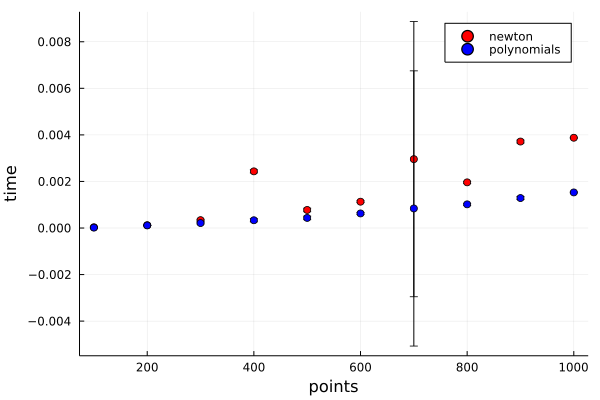

In [116]:
g = groupby(df2_to_plot,"interpolation")
scatter()
scatter!(g[1][!, "points"], g[1][!, "time_mean"],yerr = df2_to_plot.time_std, xlab = "points", ylab="time", colour =:red, label = "newton")
scatter!(g[2][!, "points"], g[2][!, "time_mean"],yerr = df2_to_plot.time_std, xlab = "points", ylab="time", colour =:blue, label = "polynomials")

## Newton vs Polynomials - wyliczanie wartości w punkcie

In [98]:
# czas obliczania wartości dla algorytmu Newtona
function newton_end_time(X,Y,res_range)
    newt = NewtonInterpolation(X,Y)
    b =  sum([@elapsed newt(i) for i in res_range])
    return b
end

# czas obliczania wartości dla polynomials
function polynomials_end_time(X,Y,res_range)
    func = fit(X,Y)
    return sum([@elapsed func(i) for i in res_range])
end

polynomials_end_time (generic function with 1 method)

In [112]:
df3 = DataFrame(points = Int64[], 
    interpolation = String[],
    time = Float64[])

,points,interpolation,time
,Int64,String,Float64


In [113]:
r = 100:100:1000
for i=r
    for j=1:10
        xt, yt = rand_points(i)
        tr = 1:0.01:i
        push!(df3, [i "newton" newton_end_time(xt,yt,tr)])
        push!(df3, [i "polynomials" polynomials_end_time(xt,yt,tr)])
    end
end

In [114]:
df3

,points,interpolation,time
,Int64,String,Float64
1,100,newton,0.0011996
2,100,polynomials,0.001347
3,100,newton,0.0013906
4,100,polynomials,0.0011211
5,100,newton,0.0011125
6,100,polynomials,0.0010278
7,100,newton,0.0013622
8,100,polynomials,0.0015027
9,100,newton,0.0012345


In [117]:
df3grouped = groupby(df3, [:points, :interpolation])
df3_to_plot = combine(df3grouped, "time" => mean, "time" => std)

,points,interpolation,time_mean,time_std
,Int64,String,Float64,Float64
1,100,newton,0.00121143,9.33648e-5
2,100,polynomials,0.00118309,0.000137221
3,200,newton,0.00436673,0.000485551
4,200,polynomials,0.00431051,0.000303018
5,300,newton,0.0104581,0.00289164
6,300,polynomials,0.00688945,0.000233235
7,400,newton,0.016851,0.000279332
8,400,polynomials,0.00978877,0.0028241
9,500,newton,0.027383,0.0031188


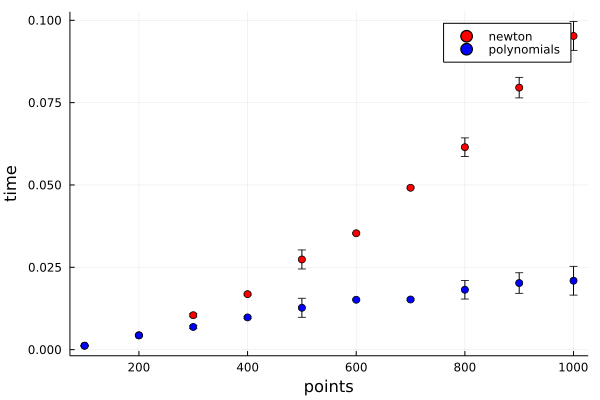

In [125]:
g = groupby(df3_to_plot,"interpolation")
scatter()
scatter!(g[1][!, "points"], g[1][!, "time_mean"],yerr = df3_to_plot.time_std, xlab = "points", ylab="time", colour =:red, label = "newton")
scatter!(g[2][!, "points"], g[2][!, "time_mean"],yerr = df3_to_plot.time_std, xlab = "points", ylab="time", colour =:blue, label = "polynomials")

# 5. Algorytm Nevile'a

In [126]:
function neville(X,Y,x_cord)
    n = length(X)
    m = zeros(Float64, n, n+1)
    
    # Pierwsza kolumna to nasze współrzędne x węzłów.
    for i in 1:n
        m[i,1] = X[i]
    end
    # Druga kolumna to wartości naszych węzłów.
    for i in 1:n
        m[i,2] = Y[i]
    end
    # Pozostałe liczymy 
    for col=3:n+1
        for row=1:n+2-col
            m[row,col] = (x_cord - X[row])*m[row+1,col-1] - (x_cord - X[row+1])*m[row,col-1]
            m[row,col] /= (X[row+1] - X[row])
        end
    end
    return m[1,n]
end

neville (generic function with 1 method)

In [147]:
xs = 1:1:10
X = 1:1:10
Y = [rand() for x in X]

func=fit(X, Y)
newt = NewtonInterpolation(X,Y)

for i in xs
    println("Point:       ", i)
    a = newt(i)
    b = l_value(i,X,Y,length(X))
    c = func(i)
    d = neville(X, Y , i)
    println("Newton:      ",a)
    println("Lagrange:    ",b)
    println("Polynomials: ",c)
    println("Neville:     ",d)
    println()
end

Point:       1
Newton:      0.8885350416083407
Lagrange:    0.8885350416083407
Polynomials: 0.8885350416084066
Neville:     0.8885350416083407

Point:       2
Newton:      0.6075884179225517
Lagrange:    0.6075884179225517
Polynomials: 0.6075884179228979
Neville:     0.6075884179225517

Point:       3
Newton:      0.7087029387099183
Lagrange:    0.7087029387099183
Polynomials: 0.7087029387103598
Neville:     1.0907640831830738

Point:       4
Newton:      0.14081415801182273
Lagrange:    0.14081415801182273
Polynomials: 0.140814158013427
Neville:     267.2063024189616

Point:       5
Newton:      0.7152303214334665
Lagrange:    0.7152303214334661
Polynomials: 0.7152303214292033
Neville:     16932.816645836643

Point:       6
Newton:      0.09585266922481939
Lagrange:    0.0958526692248195
Polynomials: 0.09585266921158109
Neville:     329305.8061460815

Point:       7
Newton:      0.6396835100487337
Lagrange:    0.6396835100487298
Polynomials: 0.6396835100268277
Neville:     3.165111215

#  6. Interpolacja funkcjami sklejanymi vs Interpolacja wielomianowa

### Funkcja1 - 5 węzłów interpolacji

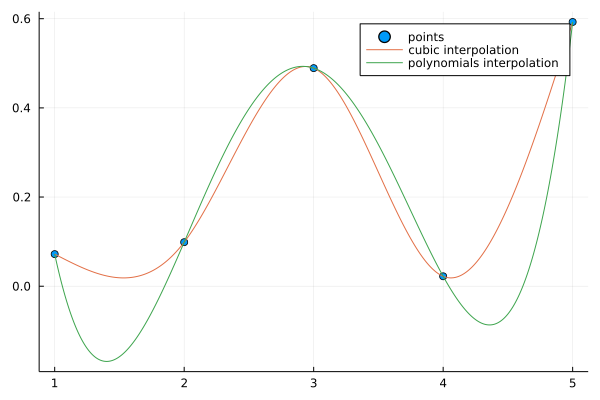

In [154]:
X =  1:1:5
Y = [rand() for x in X]

scatter(X,Y, label = "points")

xs = 1:0.01:5

cubic1 = CubicSplineInterpolation(X, Y)
y_cubic1 = [cubic1(x) for x in xs]
plot!(xs,y_cubic1, label="cubic interpolation")

func1 = fit(X, Y)
y_polyn1 = [func1(x) for x in xs]
plot!(xs,y_polyn1, label="polynomials interpolation")

### Funkcja2 - 10 węzłów interpolacji

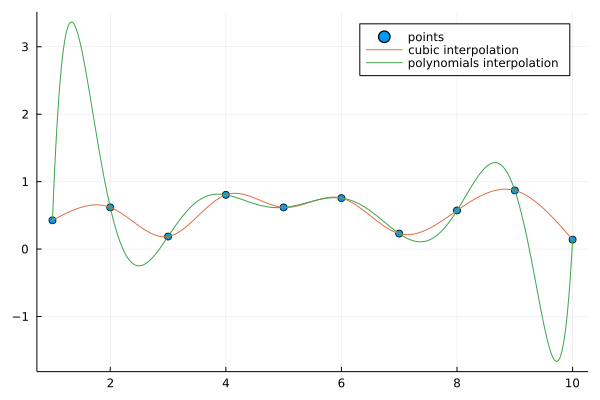

In [156]:
X =  1:1:10
Y = [rand() for x in X]

scatter(X,Y, label = "points")

xs = 1:0.01:10

cubic1 = CubicSplineInterpolation(X, Y)
y_cubic1 = [cubic1(x) for x in xs]
plot!(xs,y_cubic1, label="cubic interpolation")

func1 = fit(X, Y)
y_polyn1 = [func1(x) for x in xs]
plot!(xs,y_polyn1, label="polynomials interpolation")

### Funkcja3 - 20 węzłów interpolacji

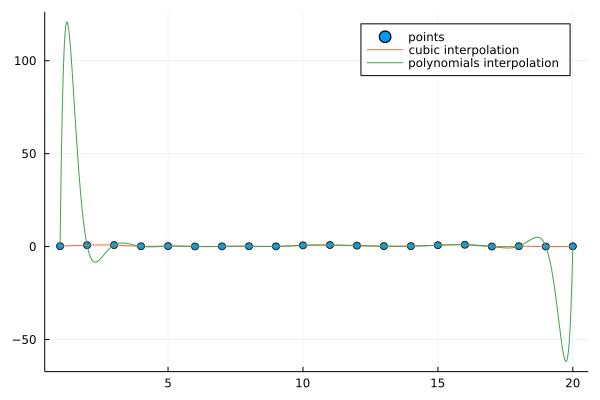

In [161]:
X =  1:1:20
Y = [rand() for x in X]

scatter(X,Y, label = "points")

xs = 1:0.01:20

cubic1 = CubicSplineInterpolation(X, Y)
y_cubic1 = [cubic1(x) for x in xs]
plot!(xs,y_cubic1, label="cubic interpolation")

func1 = fit(X, Y)
y_polyn1 = [func1(x) for x in xs]
plot!(xs,y_polyn1, label="polynomials interpolation")

Im więcej węzłów interpolacji tym mniejsza dokładność wielomianu interpolującego \
obliczonego za pomocą interpolacji wielomianowej. Jest to efekt Rungego. \
Ponadto równa odległość pomiędzy węzłami interpolacji wzmaga ten efekt. \
Używając interpolacji funkcjami sklejanymi widoczna jest znacznie większa dokładność. 